In [7]:
# Notebook-friendly version: no argparse; define functions and run locally.
import pandas as pd
import numpy as np
from pathlib import Path
import math

# ---------------------------
# Config (astronomy constants)
# ---------------------------
SYNODIC_MONTH = 29.530588853  # days
NEW_MOON_EPOCH = pd.Timestamp("2000-01-06 18:14:00", tz="UTC")
TROPICAL_YEAR = 365.2422  # days

# ---------------------------
# Utilities
# ---------------------------
def to_datetime_utc(s: pd.Series) -> pd.Series:
    dt = pd.to_datetime(s, errors="coerce", utc=True)
    if dt.dt.tz is None:
        dt = dt.dt.tz_localize("UTC")
    return dt

def normalize_angle_deg(x: np.ndarray) -> np.ndarray:
    y = np.mod(x, 360.0)
    y[y == 0.0] = 360.0
    return y

def moon_phase_label(angle_deg: float) -> str:
    a = angle_deg % 360.0
    if a < 22.5 or a >= 337.5:
        return "New Moon"
    elif a < 67.5:
        return "Waxing Crescent"
    elif a < 112.5:
        return "First Quarter"
    elif a < 157.5:
        return "Waxing Gibbous"
    elif a < 202.5:
        return "Full Moon"
    elif a < 247.5:
        return "Waning Gibbous"
    elif a < 292.5:
        return "Last Quarter"
    else:
        return "Waning Crescent"

def make_angle_bins16(angle_deg: pd.Series) -> pd.Series:
    bins = np.arange(0, 360 + 22.5, 22.5)
    labels = [f"{int(b)}–{int(b+22.5)}°" if b+22.5 <= 360 else f"{int(b)}–360°" for b in bins[:-1]]
    return pd.cut(angle_deg, bins=bins, labels=labels, right=False, include_lowest=True)

def rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(period, min_periods=period).mean()
    roll_down = down.rolling(period, min_periods=period).mean()
    rs = roll_up / roll_down
    out = 100 - (100 / (1 + rs))
    return out

def lunar_features(dates_utc: pd.Series) -> pd.DataFrame:
    days_since_epoch = (dates_utc - NEW_MOON_EPOCH).dt.total_seconds() / 86400.0
    age = np.mod(days_since_epoch, SYNODIC_MONTH)
    angle_deg = (age / SYNODIC_MONTH) * 360.0
    angle_deg = normalize_angle_deg(angle_deg)

    illum = (1.0 - np.cos(np.deg2rad(angle_deg))) / 2.0
    phase8 = [moon_phase_label(a) for a in angle_deg]

    # keep full precision (float, not bins)
    angle_precise = angle_deg.round(6)   # keep 6 decimals, change as you like

    # Harmonics
    def harmonics(deg):
        rad = np.deg2rad(deg)
        return {f"Moon_sin{k}": np.sin(k * rad) for k in range(1, 5)} | \
               {f"Moon_cos{k}": np.cos(k * rad) for k in range(1, 5)}

    harm_df = pd.DataFrame([harmonics(a) for a in angle_precise])

    return pd.DataFrame({
        "Moon_Age_Days": age,
        "Moon_Angle_Deg": angle_precise,   # << precise float degrees
        "Moon_Illumination": illum,
        "Moon_Phase_8": phase8,
    }).join(harm_df)


def solar_earth_features(dates_utc: pd.Series) -> pd.DataFrame:
    day_of_year = dates_utc.dt.dayofyear.astype(float)
    solar_angle_deg = (day_of_year / TROPICAL_YEAR) * 360.0
    solar_angle_deg = normalize_angle_deg(solar_angle_deg)
    rad = np.deg2rad(solar_angle_deg)
    feats = {
        "Solar_Angle_Deg": solar_angle_deg,
        "Solar_sin1": np.sin(rad),
        "Solar_cos1": np.cos(rad),
        "Solar_sin2": np.sin(2 * rad),
        "Solar_cos2": np.cos(2 * rad),
        "Solar_sin3": np.sin(3 * rad),
        "Solar_cos3": np.cos(3 * rad),
        "Solar_sin4": np.sin(4 * rad),
        "Solar_cos4": np.cos(4 * rad),
        "DOY": day_of_year,
        "Year": dates_utc.dt.year.astype(int),
        "Month": dates_utc.dt.month.astype(int),
        "Weekday": dates_utc.dt.weekday.astype(int),
    }
    return pd.DataFrame(feats)

def harmonic_mean(a_deg: np.ndarray, b_deg: np.ndarray) -> np.ndarray:
    a = np.asarray(a_deg, dtype=float)
    b = np.asarray(b_deg, dtype=float)
    return 2.0 / (1.0 / a + 1.0 / b)

def load_btc_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    date_col = None
    for candidate in ("date", "time"):
        if candidate in cols:
            date_col = cols[candidate]
            break
    if date_col is None:
        raise ValueError("CSV must include a Date or time column.")

    rename_map = {}
    if "open" in cols: rename_map[cols["open"]] = "Open"
    if "high" in cols: rename_map[cols["high"]] = "High"
    if "low" in cols:  rename_map[cols["low"]]  = "Low"
    if "close" in cols:rename_map[cols["close"]] = "Close"
    if "volume" in cols:rename_map[cols["volume"]] = "Volume"

    df = df.rename(columns=rename_map)
    dt = to_datetime_utc(df[date_col])
    df["DateTime_UTC"] = dt
    df["Date"] = df["DateTime_UTC"].dt.normalize()
    df = df.sort_values("DateTime_UTC").groupby("Date", as_index=False).last()

    # Ensure numeric if present
    for c in ["Open", "High", "Low", "Close", "Volume"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    return df

def build_dataset(btc_df: pd.DataFrame) -> pd.DataFrame:
    start = btc_df["Date"].min()
    end = btc_df["Date"].max()
    calendar = pd.DataFrame({"Date": pd.date_range(start, end, freq="D", tz="UTC")})

    # Only keep available price columns
    price_cols = ["Open", "High", "Low", "Close", "Volume"]
    price_cols_existing = [c for c in price_cols if c in btc_df.columns]
    btc = btc_df[["Date"] + price_cols_existing].copy()

    btc = calendar.merge(btc, on="Date", how="left")
    close = btc["Close"]

    btc["Return_D1"] = close.pct_change().shift(-1)

    # Moving averages only if Close exists
    if "Close" in btc.columns:
        for w in (10, 50, 200):
            btc[f"SMA_{w}"] = close.rolling(w, min_periods=w).mean()
        btc["SMA10_above_SMA50"] = (btc["SMA_10"] > btc["SMA_50"]).astype("Int8")
        btc["RSI_14"] = rsi(close, 14)

    # Moon + Solar features
    moon = lunar_features(btc["Date"])
    solar = solar_earth_features(btc["Date"])
    out = btc.join(moon).join(solar)

    out["HarmonicMean_Moon_Solar_Deg"] = harmonic_mean(
        out["Moon_Angle_Deg"].values, out["Solar_Angle_Deg"].values
    )

    out["Date"] = out["Date"].dt.date
    return out

# -------- Run in notebook: set your input path ---------
input_path = "CRYPTO_BTCUSD, 1D.csv"  # change this to your local path when running locally
btc_raw = load_btc_csv(input_path)
dataset = build_dataset(btc_raw)

# Save outputs next to notebook working dir
csv_out = "btc_moon_earth_features.csv"
xlsx_out = "btc_moon_earth_features.xlsx"
dataset.to_csv(csv_out, index=False)
with pd.ExcelWriter(xlsx_out, engine="xlsxwriter", datetime_format="yyyy-mm-dd") as w:
    dataset.to_excel(w, sheet_name="Dataset", index=False)

csv_out, xlsx_out


('btc_moon_earth_features.csv', 'btc_moon_earth_features.xlsx')

In [10]:
import matplotlib.pyplot as plt
from typing import Tuple, Dict

def zigzag_pivots(
    dates: pd.Series,
    closes: pd.Series,
    deviation_pct: float = 5.0,
    depth: int = 10,
    extend_to_last: bool = True,
) -> pd.DataFrame:
    """
    ZigZag pivot detection (percent reversal + depth), pure price.
    Returns a DataFrame with pivot indices, dates, prices, and LOW/HIGH type.
    """
    px = pd.DataFrame({"Date": pd.to_datetime(dates), "Close": pd.to_numeric(closes, errors="coerce")})
    px = px.dropna(subset=["Close"]).sort_values("Date").reset_index(drop=True)

    prices = px["Close"].values
    n = len(prices)
    if n == 0:
        raise ValueError("No valid prices.")

    def pct_change(a, b):
        return 0.0 if a == 0 else (b - a) / a * 100.0

    piv_idx = [0]
    piv_prc = [prices[0]]
    trend = 0          # 0=unknown, +1=up leg, -1=down leg
    extreme_idx = 0    # index of current extreme in the active leg

    for i in range(1, n):
        p = prices[i]
        last_idx = piv_idx[-1]
        last_prc = piv_prc[-1]

        if trend == 0:
            # initialize trend after min depth when deviation is met
            if i - last_idx >= depth:
                chg = pct_change(last_prc, p)
                if chg >= deviation_pct:
                    trend = +1
                    extreme_idx = i
                elif chg <= -deviation_pct:
                    trend = -1
                    extreme_idx = i
            else:
                # keep tracking an initial extreme in case we switch quickly
                if p > prices[extreme_idx]:
                    extreme_idx = i
                if p < prices[extreme_idx] and prices[extreme_idx] != p:
                    extreme_idx = i

        elif trend == +1:
            # Up leg: update high extreme
            if p >= prices[extreme_idx]:
                extreme_idx = i
            # Reverse when drawdown from the extreme >= deviation_pct and depth satisfied
            drawdown = pct_change(prices[extreme_idx], p)  # negative when falling
            if drawdown <= -deviation_pct and (i - last_idx) >= depth:
                piv_idx.append(extreme_idx)
                piv_prc.append(prices[extreme_idx])
                trend = -1
                extreme_idx = i

        else:  # trend == -1
            # Down leg: update low extreme
            if p <= prices[extreme_idx]:
                extreme_idx = i
            # Reverse when bounce from the extreme >= deviation_pct and depth satisfied
            bounce = pct_change(prices[extreme_idx], p)  # positive when rising
            if bounce >= deviation_pct and (i - last_idx) >= depth:
                piv_idx.append(extreme_idx)
                piv_prc.append(prices[extreme_idx])
                trend = +1
                extreme_idx = i

    # Add last extreme as final pivot if different
    if piv_idx[-1] != extreme_idx:
        piv_idx.append(extreme_idx)
        piv_prc.append(prices[extreme_idx])

    # Optionally extend to last price point for drawing continuity
    plot_idx = piv_idx.copy()
    plot_prc = piv_prc.copy()
    if extend_to_last and plot_idx[-1] != n - 1:
        plot_idx.append(n - 1)
        plot_prc.append(prices[-1])

    # Classify pivot types (interior points only)
    types = []
    for k in range(len(piv_idx)):
        if k == 0 or k == len(piv_idx) - 1:
            types.append("")  # edges unclassified
        else:
            prev_p = piv_prc[k - 1]; cur_p = piv_prc[k]; nxt_p = piv_prc[k + 1]
            types.append("LOW" if (cur_p <= prev_p and cur_p <= nxt_p) else "HIGH")

    pivots = pd.DataFrame({
        "PivotIdx": piv_idx,
        "PivotDate": px.loc[piv_idx, "Date"].values,
        "PivotPrice": piv_prc,
        "Type": types
    })

    # Also return a “plot” version of the line (with optional last extension)
    line = pd.DataFrame({
        "Idx": plot_idx,
        "Date": px.loc[plot_idx, "Date"].values,
        "Price": plot_prc
    })

    return pivots, line, px

def zigzag_signals_from_pivots(pivots: pd.DataFrame, exec_mode: str = "next_close", px: pd.DataFrame = None) -> pd.DataFrame:
    """
    Convert LOW/HIGH pivots to BUY/SELL signals. Execution:
      - "next_close": trade at next bar's Close after the pivot bar
      - "same_close": trade at pivot bar's Close
    """
    sig = pivots[pivots["Type"].isin(["LOW", "HIGH"])].copy()
    sig["Action"] = np.where(sig["Type"] == "LOW", "BUY", "SELL")
    if exec_mode not in ("next_close", "same_close"):
        raise ValueError("exec_mode must be 'next_close' or 'same_close'")

    if exec_mode == "same_close":
        sig["ExecDate"] = sig["PivotDate"]
        sig["ExecPrice"] = sig["PivotPrice"]
    else:
        # map pivot index + 1 to next bar
        next_idx = sig["PivotIdx"].values + 1
        # clamp at last bar
        next_idx = np.minimum(next_idx, len(px) - 1)
        sig["ExecDate"] = px.loc[next_idx, "Date"].values
        sig["ExecPrice"] = px.loc[next_idx, "Close"].values

    return sig[["Action", "ExecDate", "ExecPrice", "PivotDate", "PivotPrice"]]

def plot_zigzag(
    px: pd.DataFrame,
    line: pd.DataFrame,
    pivots: pd.DataFrame,
    signals: pd.DataFrame,
    title: str = "ZigZag (price-only) with BUY/SELL"
):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(px["Date"], px["Close"], label="Close", linewidth=1.2)

    # ZigZag line
    ax.plot(line["Date"], line["Price"], linewidth=2.0, label="ZigZag")

    # Markers
    lows = pivots[pivots["Type"] == "LOW"]
    highs = pivots[pivots["Type"] == "HIGH"]
    ax.scatter(lows["PivotDate"], lows["PivotPrice"], marker="^", s=70, label="Pivot LOW (BUY)", zorder=3)
    ax.scatter(highs["PivotDate"], highs["PivotPrice"], marker="v", s=70, label="Pivot HIGH (SELL)", zorder=3)

    # Execution markers (optional; comment out if you only want pivots)
    buys = signals[signals["Action"] == "BUY"]
    sells = signals[signals["Action"] == "SELL"]
    ax.scatter(buys["ExecDate"], buys["ExecPrice"], marker="o", s=30, label="BUY exec", zorder=4)
    ax.scatter(sells["ExecDate"], sells["ExecPrice"], marker="x", s=40, label="SELL exec", zorder=4)

    ax.set_title(title)
    ax.set_xlabel("Date"); ax.set_ylabel("Price")
    ax.legend()
    plt.show()

# -------------------------
# USAGE (works with your btc_df = ['Date','Close'])
# -------------------------
# Example params analogous to your Pine inputs:
deviation_pct = 5.0   # input.float in Pine
depth = 10            # input.int in Pine
extend_to_last = True
exec_mode = "next_close"  # or "same_close"



In [11]:
dataset

,Date,Open,High,Low,Close,Return_D1,SMA_10,SMA_50,SMA_200,SMA10_above_SMA50,...,Solar_cos2,Solar_sin3,Solar_cos3,Solar_sin4,Solar_cos4,DOY,Year,Month,Weekday,HarmonicMean_Moon_Solar_Deg
0,2021-05-03,56617.0825,58984.0825,56507.0700,57209.9900,-0.069403,NaN,NaN,NaN,0,...,-0.462225,0.064600,0.997911,0.819767,-0.572697,123.0,2021,5,0,163.771709
1,2021-05-04,57214.2275,57239.9950,53085.2875,53239.4225,0.080250,NaN,NaN,NaN,0,...,-0.431448,0.115991,0.993250,0.778451,-0.627706,124.0,2021,5,1,167.183457
2,2021-05-05,53225.2725,57972.7550,52946.1525,57511.9100,-0.018642,NaN,NaN,NaN,0,...,-0.400160,0.167074,0.985944,0.733449,-0.679744,125.0,2021,5,2,170.490560
3,2021-05-06,57513.2600,58426.7400,55270.4925,56439.7950,0.016744,NaN,NaN,NaN,0,...,-0.368398,0.217712,0.976013,0.684976,-0.728565,126.0,2021,5,3,173.703030
4,2021-05-07,56437.5075,58726.7550,55304.0325,57384.8100,0.027623,NaN,NaN,NaN,0,...,-0.336201,0.267770,0.963483,0.633261,-0.773938,127.0,2021,5,4,176.829645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,2025-09-16,115406.0700,116997.1500,114813.9800,116826.2900,-0.002910,114389.901,114382.4770,102817.26155,1,...,-0.870917,0.717494,0.696565,-0.855991,0.516991,259.0,2025,9,1,267.487928
1598,2025-09-17,116826.3000,117324.1100,114798.4000,116486.3800,0.005370,114920.832,114353.3908,102969.55530,1,...,-0.887306,0.752471,0.658625,-0.818418,0.574623,260.0,2025,9,2,273.453679
1599,2025-09-18,116486.3800,117932.8800,116154.9300,117111.8700,-0.012218,115424.569,114339.3272,103083.93975,1,...,-0.902645,0.785445,0.618931,-0.776972,0.629535,261.0,2025,9,3,279.225403
1600,2025-09-19,117111.8700,117507.2100,115149.8200,115680.9500,0.001450,115837.228,114337.7358,103231.22115,1,...,-0.916915,0.816327,0.577590,-0.731849,0.681467,262.0,2025,9,4,284.816420


In [15]:
import pandas as pd
import numpy as np

def attach_zigzag_signals(
    dataset: pd.DataFrame,
    *,
    deviation_pct: float = 5.0,   # like TradingView "Price deviation for reversals (%)"
    depth: int = 10,               # like TradingView "Pivot legs"
    exec_mode: str = "next_close"  # "next_close" or "same_close"
) -> pd.DataFrame:
    """
    Add a pure price-based ZigZag BUY/SELL 'Signal' column to the dataset.

    Requirements in `dataset`:
      - Columns: 'Date', 'Close' (others are preserved untouched)
      - 'Date' may be string/ts (any tz); function normalizes safely

    Returns:
      New DataFrame with all original columns + 'Signal' ("" | "BUY" | "SELL")

    Notes:
      - Purely price-based (Close only). No indicators, no lunar features involved.
      - Reversal is confirmed using `deviation_pct` and `depth` (bars between pivots).
      - Execution:
          - "next_close": fills occur at the next bar's Close after a pivot
          - "same_close": fills at the pivot bar's Close
    """
    if not {"Date", "Close"}.issubset(dataset.columns):
        raise ValueError("`dataset` must contain 'Date' and 'Close' columns.")

    # Work on a copy; never mutate caller's data
    df = dataset.copy()

    # Normalize Date for stable joins (strip time/tz)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.normalize()
    if df["Date"].isna().all():
        raise ValueError("All 'Date' values are NaT after parsing.")

    # Prepare clean, sorted price series for ZigZag
    px = df[["Date", "Close"]].dropna(subset=["Close"]).copy()
    px["Close"] = pd.to_numeric(px["Close"], errors="coerce")
    px = px.dropna(subset=["Close"]).sort_values("Date").reset_index(drop=True)
    n = len(px)
    if n == 0:
        out = df.copy()
        out["Signal"] = ""
        return out

    if exec_mode not in ("next_close", "same_close"):
        raise ValueError("exec_mode must be 'next_close' or 'same_close'")

    prices = px["Close"].to_numpy(dtype=float)

    def pct_change(a: float, b: float) -> float:
        return 0.0 if a == 0 else (b - a) / a * 100.0

    # ---------------- ZigZag pivot detection (percent reversal + depth) ----------------
    piv_idx = [0]
    piv_prc = [prices[0]]
    trend = 0            # 0=unknown, +1=up leg, -1=down leg
    extreme_idx = 0      # index of current extreme inside active leg

    for i in range(1, n):
        p = prices[i]
        last_idx = piv_idx[-1]
        last_prc = piv_prc[-1]

        if trend == 0:
            # Initialize trend only after min depth when deviation is met
            if i - last_idx >= depth:
                chg = pct_change(last_prc, p)
                if chg >= deviation_pct:
                    trend, extreme_idx = +1, i
                elif chg <= -deviation_pct:
                    trend, extreme_idx = -1, i
        elif trend == +1:
            # Up leg: update high extreme
            if p >= prices[extreme_idx]:
                extreme_idx = i
            drawdown = pct_change(prices[extreme_idx], p)  # negative when falling
            if drawdown <= -deviation_pct and (i - last_idx) >= depth:
                # Confirm pivot HIGH at extreme
                piv_idx.append(extreme_idx)
                piv_prc.append(prices[extreme_idx])
                trend, extreme_idx = -1, i
        else:
            # Down leg: update low extreme
            if p <= prices[extreme_idx]:
                extreme_idx = i
            bounce = pct_change(prices[extreme_idx], p)    # positive when rising
            if bounce >= deviation_pct and (i - last_idx) >= depth:
                # Confirm pivot LOW at extreme
                piv_idx.append(extreme_idx)
                piv_prc.append(prices[extreme_idx])
                trend, extreme_idx = +1, i

    # Append final extreme if different
    if piv_idx[-1] != extreme_idx:
        piv_idx.append(extreme_idx)
        piv_prc.append(prices[extreme_idx])

    # Classify interior pivots as LOW or HIGH
    types = []
    for k in range(len(piv_idx)):
        if k == 0 or k == len(piv_idx) - 1:
            types.append("")  # edges unclassified
        else:
            prev_p, cur_p, nxt_p = piv_prc[k-1], piv_prc[k], piv_prc[k+1]
            types.append("LOW" if (cur_p <= prev_p and cur_p <= nxt_p) else "HIGH")

    pivots = pd.DataFrame({
        "PivotIdx": piv_idx,
        "PivotDate": px.loc[piv_idx, "Date"].values,
        "PivotPrice": piv_prc,
        "Type": types
    })

    # ---------------- Convert pivots to executions ----------------
    sig = pivots[pivots["Type"].isin(["LOW", "HIGH"])].copy()
    if sig.empty:
        out = df.copy()
        out["Signal"] = ""
        return out

    sig["Action"] = np.where(sig["Type"] == "LOW", "BUY", "SELL")

    if exec_mode == "same_close":
        sig["ExecDate"] = sig["PivotDate"]
        sig["ExecPrice"] = sig["PivotPrice"].astype(float)
    else:
        next_idx = np.minimum(sig["PivotIdx"].to_numpy(int) + 1, n - 1)
        sig["ExecDate"] = px.loc[next_idx, "Date"].values
        sig["ExecPrice"] = px.loc[next_idx, "Close"].astype(float).values

    # ---------------- Merge back to the full dataset by execution date ----------------
    sig_map = sig.set_index("ExecDate")["Action"].to_dict()

    out = df.copy()
    out["Signal"] = ""
    # Normalize again in case caller had fresh dates since the copy
    out["Date"] = pd.to_datetime(out["Date"], errors="coerce").dt.normalize()
    mask = out["Date"].isin(sig_map.keys())
    out.loc[mask, "Signal"] = out.loc[mask, "Date"].map(sig_map).fillna("")

    return out


In [17]:
# Assuming `dataset` is your btc_moon_earth_features DataFrame (with Date, Close, etc.)
dataset_with_signals = attach_zigzag_signals(
    dataset,
    deviation_pct=5.0,   # tweak like in TradingView
    depth=10,            # min bars between pivots
    exec_mode="next_close"
)

# Optional: save
# dataset_with_signals.to_csv("btc_moon_earth_features_with_signals.csv", index=False)
# dataset_with_signals.to_excel("btc_moon_earth_features_with_signals.xlsx", index=False)

# Save outputs
csv_out = "btc_moon_earth_features_with_signals.csv"
xlsx_out = "btc_moon_earth_features_with_signals.xlsx"
dataset_with_signals.to_csv(csv_out, index=False)
with pd.ExcelWriter(xlsx_out, engine="xlsxwriter", datetime_format="yyyy-mm-dd") as w:
    dataset_with_signals.to_excel(w, sheet_name="Dataset", index=False)

csv_out, xlsx_out


('btc_moon_earth_features_with_signals.csv',
 'btc_moon_earth_features_with_signals.xlsx')

<Figure size 1000x600 with 0 Axes>

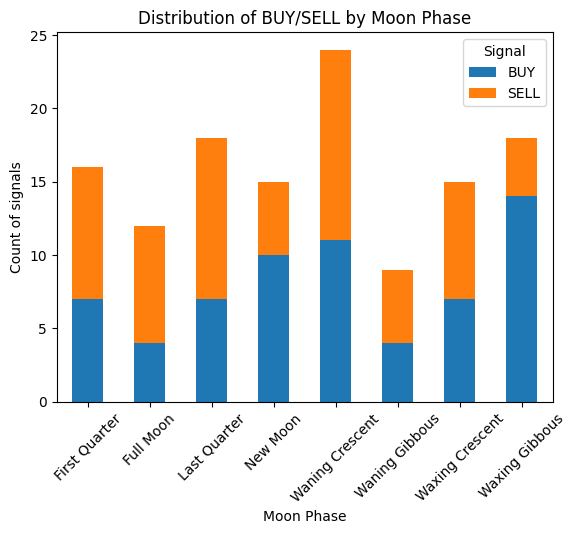

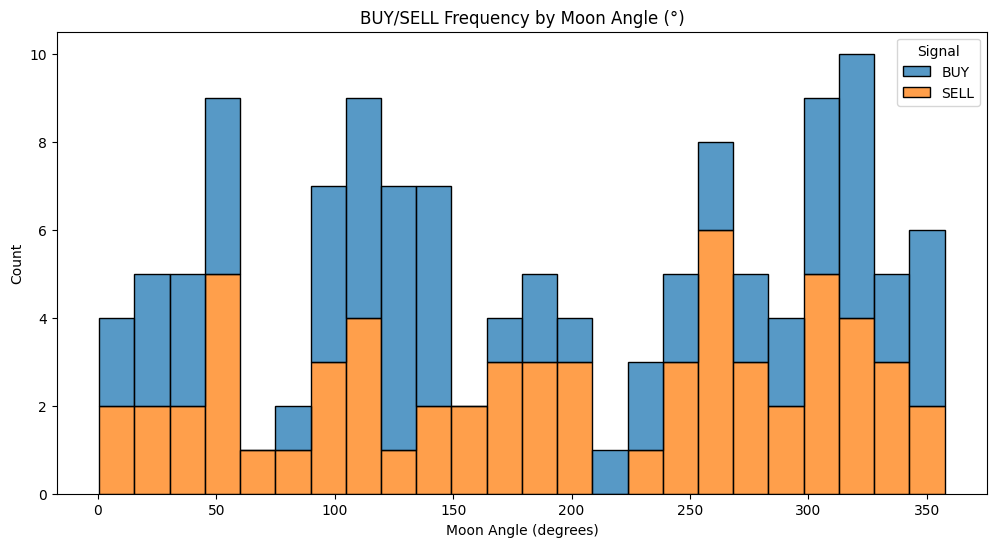

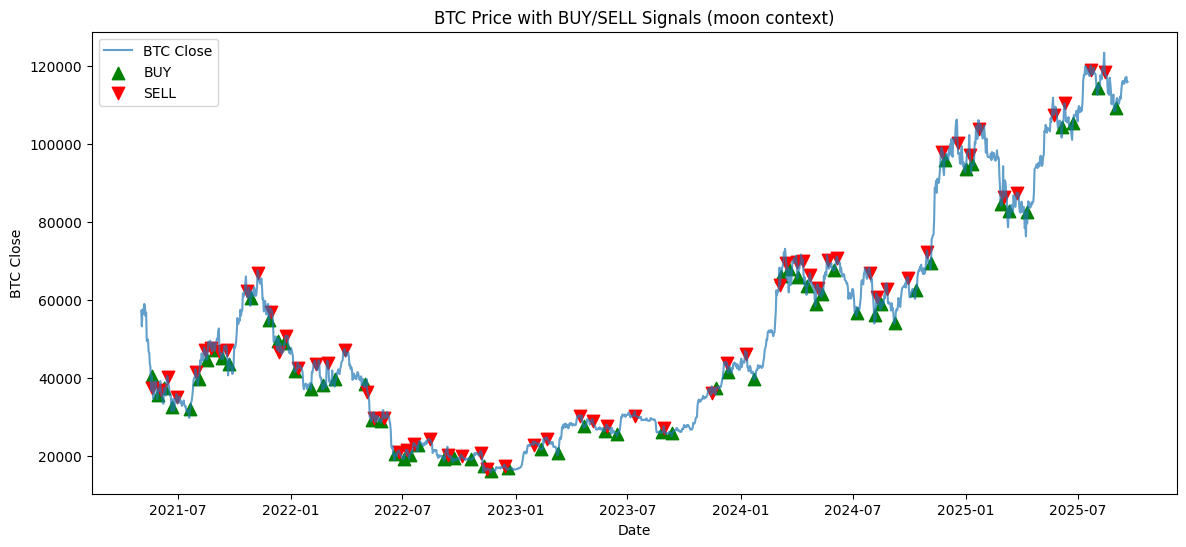

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your file
df = pd.read_csv("btc_moon_earth_features_with_signals.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Filter only rows with signals
signals = df[df["Signal"].isin(["BUY", "SELL"])]

# ------------------------
# 1. Distribution by Moon Phase
# ------------------------
phase_counts = signals.groupby(["Moon_Phase_8", "Signal"]).size().unstack(fill_value=0)

plt.figure(figsize=(10,6))
phase_counts.plot(kind="bar", stacked=True)
plt.title("Distribution of BUY/SELL by Moon Phase")
plt.ylabel("Count of signals")
plt.xlabel("Moon Phase")
plt.xticks(rotation=45)
plt.show()

# ------------------------
# 2. BUY/SELL Frequency vs Moon Angle
# ------------------------
plt.figure(figsize=(12,6))
sns.histplot(data=signals, x="Moon_Angle_Deg", hue="Signal", bins=24, multiple="stack")
plt.title("BUY/SELL Frequency by Moon Angle (°)")
plt.xlabel("Moon Angle (degrees)")
plt.ylabel("Count")
plt.show()

# ------------------------
# 3. Overlay BTC with Signals (colored by Moon Phase)
# ------------------------
plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["Close"], label="BTC Close", alpha=0.7)

buy_points = signals[signals["Signal"]=="BUY"]
sell_points = signals[signals["Signal"]=="SELL"]

plt.scatter(buy_points["Date"], buy_points["Close"], marker="^", color="green", s=80, label="BUY")
plt.scatter(sell_points["Date"], sell_points["Close"], marker="v", color="red", s=80, label="SELL")

plt.title("BTC Price with BUY/SELL Signals (moon context)")
plt.xlabel("Date")
plt.ylabel("BTC Close")
plt.legend()
plt.show()
